# Pytorch
Ejemplo de clasificador con Pytorch, comentado en español. 

El cuaderno de Jupyter se ha desarrollado con Visual Code y puedes encontrar el código en https://github.com/josegemez/pytorch_mnist 

Se ha desarrollado en python 3.10.4 

## Import
Con las primeras lineas vamos a importar los paquetes que básicos de Pytorch. 

In [1]:
import torch
import torchvision

## Variables Generales

In [2]:
batch_size_train = 128
batch_size_test = 512

## Transformaciones 

In [3]:
transforms=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])

## Dataset Entrenamiento

In [4]:
dataset_mnist = torchvision.datasets.MNIST('/files/', train=True, download=True, transform=transforms)                    

## Dataloader

In [5]:
train_loader = torch.utils.data.DataLoader(dataset_mnist,  batch_size=batch_size_train, shuffle=True,num_workers=1,pin_memory=True)

Vamos a ver que "pinta" tiene cada elemento del cargador

In [6]:
x, y = next(iter(train_loader)) #asignamos el primer batch a las variables x e y. La variable X contrendra las imagenes e y contrendra las etiquetas

x es un batch, por lo que la primera dimensión coincidira con el batch size 

In [7]:
from matplotlib.pyplot import imshow

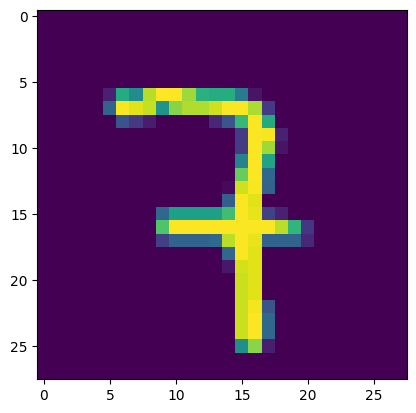

In [8]:
imshow(x[0].view(28,28).numpy()); # transformamos el primer elemento del batch una matriz de numpy y mostramos con matplotlib

In [9]:
y

tensor([7, 2, 1, 8, 2, 9, 0, 1, 0, 7, 6, 6, 9, 4, 1, 7, 5, 7, 5, 4, 1, 3, 0, 2,
        0, 4, 8, 6, 6, 3, 9, 3, 4, 7, 2, 2, 5, 2, 4, 4, 7, 1, 8, 9, 0, 4, 7, 0,
        3, 6, 1, 4, 9, 7, 7, 9, 1, 1, 5, 3, 9, 8, 8, 9, 9, 5, 8, 0, 4, 8, 7, 2,
        6, 3, 2, 3, 2, 5, 1, 7, 5, 5, 9, 3, 3, 7, 1, 3, 1, 2, 9, 4, 7, 4, 1, 3,
        4, 1, 0, 0, 5, 4, 4, 6, 4, 3, 4, 2, 0, 2, 2, 7, 4, 6, 9, 3, 6, 1, 2, 9,
        4, 0, 6, 2, 6, 0, 9, 0])

## Dataset Test

In [10]:
dataset_mnist_test = torchvision.datasets.MNIST('/files/', train=False, download=True, transform=transforms)  # Train ahora se pone en False    
test_loader = torch.utils.data.DataLoader(dataset_mnist_test,  batch_size=batch_size_test, shuffle=True, num_workers=1,pin_memory=True)              

Ya tenemos los datos preparados, ahora vamos a crear la red

In [11]:
learning_rate   =   0.01
momentum   =   0.5
n_epochs = 10


In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np

## MLP

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28,40) #capa "fuly connect" entrada 28*28 (tamaño de la imagen) 50 neuronas
        self.fc1_drop = nn.Dropout(0.2) #dropout (regularizacion) 20% 
        self.fc2 = nn.Linear(40, 20) #capa fully connect 50 neuronas 
        self.fc2_drop = nn.Dropout(0.2) #dropout (regularizacion) 20%
        self.fc3 = nn.Linear(20, 10) #capa de salida numero de salida igual al de etiquetas

    def forward(self, x):
        x = x.view(-1, 28*28) #cambia la forma del tensor, -1 para quitar la dimensiones anteriores y dejarlo todo en una vector de 256 elementos
        x = F.relu(self.fc1(x)) #capa fully connect y luego activacion relu
        x = self.fc1_drop(x) #dropout (regularizacion)
        x = F.relu(self.fc2(x)) #capa fully connect y luego activacion relu
        x = self.fc2_drop(x) #dropout (regularizacion)
        return F.log_softmax(self.fc3(x), dim=1) #soft max (estimacion estadistica 0-1 de la probabildad de que sea de un etiqueta u otra)

## Convolutional

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [14]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')
device

device(type='cuda')

In [15]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
criterion =  nn.CrossEntropyLoss().to(device)


In [16]:
model

Net(
  (fc1): Linear(in_features=784, out_features=40, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=40, out_features=20, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
)

In [17]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

In [18]:
for epoch in range(n_epochs):
  epoch_train_loss = []
  epoch_train_acc = []
  epoch_test_loss = []
  epoch_test_acc = []
  model.train() #modelo en modo entranamiento
   #perdida de la primera epoca
  with tqdm(train_loader, unit='batch') as tepoch: #tqdm para ver la barra de progreso por batch
    for data, target in tepoch: #en cada batch data la imagen de 28x28 y target la prediccion
      model.train()
      tepoch.set_description(f'Epoch {epoch}') #texto al final de la barra de progreso
      data, target = data.to(device=device, non_blocking=True), target.to(device=device, non_blocking=True).long() #se pasan lo datos y las etiquetas al "device"
      optimizer.zero_grad() #se inicializan los gradientes
      output = model(data) #se realiza la predicción propagación haciea adelante
      loss = F.nll_loss(output, target) #se calcula la funcion de perdida entre los valores predichos (output) y los valores reales (target)
      pred = output.data.max(1, keepdim=True)[1] #valores predichos
      correct = pred.eq(target.data.view_as(pred)).sum()
      accuracy = correct.item()/batch_size_train
      epoch_train_acc.append(accuracy)
      epoch_train_loss.append(loss.cpu().item()) #se guardan el valor de la perdida
      loss.backward() #se realiza la retropropagación 
      optimizer.step() #se realiza un paso adelante con el learning rate y el gradiente calculado

  model.eval()
  with tqdm(test_loader, unit='batch') as tepoch:
    with torch.no_grad():
      for data, target in tepoch:
        data, target = data.to(device=device, non_blocking=True), target.to(device=device, non_blocking=True).long() #se pasan lo datos y las etiquetas al "device"
        output = model(data) #se realiza la predicción propagación haciea adelante
        t_loss = F.nll_loss(output, target) #se calcula la funcion de perdida entre los valores predichos (output) y los valores reales (target)    
        pred = output.data.max(1, keepdim=True)[1] #valores predichos
        correct = pred.eq(target.data.view_as(pred)).sum()    
        test_accuracy = correct.item()/batch_size_test
        epoch_test_acc.append(test_accuracy)
        epoch_test_loss.append(t_loss.cpu().item()) #se guardan el valor de la perdida
  scheduler.step() #se realiza un paso para cambiar el learning rate
  print(f'Epoch {epoch}: Train loss {np.mean(epoch_train_loss)} Test loss {np.mean(epoch_test_loss)} Train accuracy {np.mean(epoch_train_acc)} Test accuracy {np.mean(epoch_test_acc)}')
  train_loss.append(np.mean(epoch_train_loss))
  test_loss.append(np.mean(epoch_test_loss))
  train_acc.append(np.mean(epoch_train_acc))
  test_acc.append(np.mean(epoch_test_acc))

100%|██████████| 20/20 [00:04<00:00,  4.49batch/s]


Epoch 0: Train loss 1.2782554007542413 Test loss 0.48828921020030974 Train accuracy 0.5953491471215352 Test accuracy 0.85859375


100%|██████████| 20/20 [00:04<00:00,  4.46batch/s]


Epoch 1: Train loss 0.6543829740364668 Test loss 0.3456348791718483 Train accuracy 0.7903784648187633 Test accuracy 0.88388671875


100%|██████████| 20/20 [00:04<00:00,  4.47batch/s]


Epoch 2: Train loss 0.5583665689298594 Test loss 0.3144857078790665 Train accuracy 0.8270255863539445 Test accuracy 0.88984375


100%|██████████| 20/20 [00:04<00:00,  4.41batch/s]


Epoch 3: Train loss 0.5106094326418854 Test loss 0.29314645007252693 Train accuracy 0.8427505330490405 Test accuracy 0.894921875


100%|██████████| 20/20 [00:04<00:00,  4.52batch/s]


Epoch 4: Train loss 0.4815676656486129 Test loss 0.28434939309954643 Train accuracy 0.8523787313432836 Test accuracy 0.89599609375


100%|██████████| 20/20 [00:04<00:00,  4.42batch/s]


Epoch 5: Train loss 0.46735828276127894 Test loss 0.2716369077563286 Train accuracy 0.8576259328358209 Test accuracy 0.89814453125


100%|██████████| 20/20 [00:04<00:00,  4.44batch/s]


Epoch 6: Train loss 0.45967956970749635 Test loss 0.26768845692276955 Train accuracy 0.8620569029850746 Test accuracy 0.900390625


100%|██████████| 20/20 [00:04<00:00,  4.51batch/s]


Epoch 7: Train loss 0.451133216081906 Test loss 0.26638443395495415 Train accuracy 0.8654384328358209 Test accuracy 0.900390625


100%|██████████| 20/20 [00:04<00:00,  4.39batch/s]


Epoch 8: Train loss 0.4491463164403749 Test loss 0.2647781200706959 Train accuracy 0.8659714818763327 Test accuracy 0.90166015625


100%|██████████| 20/20 [00:04<00:00,  4.16batch/s]

Epoch 9: Train loss 0.4460986499339024 Test loss 0.26112230271101 Train accuracy 0.8665878198294243 Test accuracy 0.90166015625


In [22]:
import matplotlib.pyplot as plt

In [23]:
def plot_losses(train_loss, test_loss, save_to_file=None):
    fig = plt.figure()
    epochs = len(train_loss)
    plt.plot(range(epochs), train_loss, 'bo', label='Training loss')
    plt.plot(range(epochs), test_loss,  label='Test loss', c="red")
    plt.title('Training and test loss')
    plt.legend()
    plt.ylim([0, 3])
    if save_to_file:
        fig.savefig()


def plot_accuracies(train_acc, test_acc, save_to_file=None):
    fig = plt.figure()
    epochs = len(train_acc)
    plt.plot(range(epochs), train_acc, 'bo', label='Training accuracy')
    plt.plot(range(epochs), test_acc,  label='Test accuracy', c="red")
    plt.title('Training and test accuracy')
    plt.legend()
    plt.ylim([0, 1])
    if save_to_file:
        fig.savefig(save_to_file)

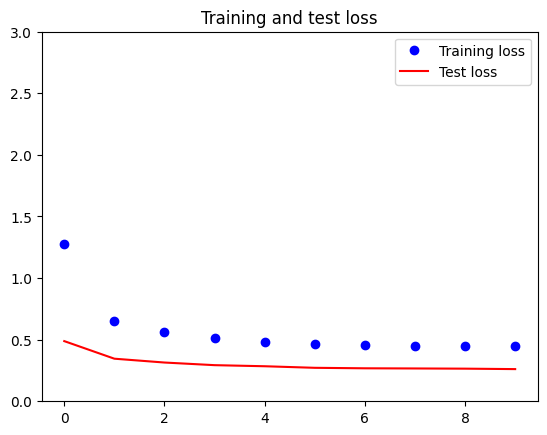

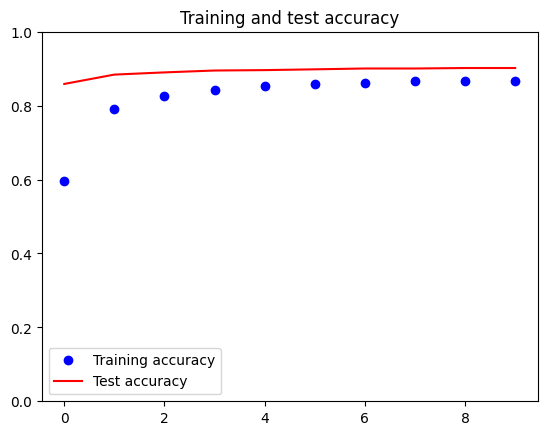

In [24]:
plot_losses(train_loss, test_loss, save_to_file=None)
plot_accuracies(train_acc, test_acc, save_to_file=None)